# Data inspector

## 0. Imports

In [1]:
#To be at project directory root and not in the Notebooks folder
%cd /storage2/mwildi/CBS2

#Imports
import lmdb
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
import glob

/storage2/mwildi/CBS2


## 1. Read dataset

In [2]:
dataset_path = "dataset/13dec"
repetitions = [x[0] for x in os.walk(dataset_path)][1:]
print('Found {} repetitions'.format(len(repetitions)))
#print(repetitions)
train_paths = [x[0] for x in os.walk(dataset_path + os.path.sep + 'train')][1:]
val_paths = [x[0] for x in os.walk(dataset_path + os.path.sep + 'val')][1:]
print('Found {} train episodes and {} val episodes'.format(len(train_paths), len(val_paths)))
#print(val_paths)

Found 0 repetitions
Found 0 train episodes and 0 val episodes


### 1.1 Decode dataset

In [3]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

def decode_data(data, kind='rgb'):
    if kind == 'loc' or kind == 'rot' or kind == 'spd' or kind == 'cmd' or kind == 'cam_location' or kind == 'cam_rotation':
        return np.frombuffer(data, dtype=np.float32)

    img = np.frombuffer(data, dtype=np.uint8)

    if kind == 'trafficlights':
        #return np.frombuffer(data, dtype=np.int8)
        return int.from_bytes(data, 'little')
    elif kind == 'rgb':
        img = img.reshape((160, 384, 3))
    elif kind == 'segmentation':
        img = img.reshape((160, 384))
    elif kind == 'birdview':
        img = img.reshape((96, 96, -1))
        
    else:
        # raise ValueError(f"Not known type {kind}. Choose from: rgb, birdview, segmentation.")
        raise ValueError("Not known type {}. Choose from: rgb, birdview, segmentation.".format(kind)) 

    return img

def decode_frame(step):
    data = {'rgb':None, 'segmentation': None, 'birdview': None, 'loc': None, 'rot': None, 'spd': None, 'cmd': None, 'trafficlights': None, 'cam_location': None, 'cam_rotation': None}

    for t in data.keys():
        d = dataset["{}_{:04d}".format(t, step)]
        data[t] = decode_data(d, kind=t)

    return data

In [30]:
def get_red_tl():
    is_red_tl = []
    speed = []
    for i in range(int(dataset['len'].decode())):
        is_red_tl.append(decode_frame(i)['trafficlights'])
    c = Counter(is_red_tl)
    n_red_frames = c[0]
    n_frames = sum(c.values())
    
    level_changes = 0
    for i,tl in enumerate(is_red_tl):
        if (i != 0 and tl != old_tl):
            level_changes += 1
        old_tl = tl
    red_lights = math.floor(level_changes/2)
    infos = [red_lights, n_red_frames, n_frames]
    
    return infos

def get_red_tl_by_cmd():
    is_red_tl = []
    speed = []
    for i in range(int(dataset['len'].decode())):
        if decode_frame(i)['trafficlights']:
            cmd = int(decode_frame(i)['cmd'])
            is_red_tl.append(cmd)
        else:
            is_red_tl.append(0)
    c = Counter(is_red_tl)
    #print(c)
    no_red = c[0]
    red_l = c[1]
    red_r = c[2]
    red_s = c[3]
    red_f = c[4]
    n_frames = sum(c.values())
    n_red_frames = n_frames - no_red
    
    level_changes = 0
    for i,tl in enumerate(is_red_tl):
        if (i != 0 and tl != old_tl):
            level_changes += 1
        old_tl = tl
    red_lights = math.floor(level_changes/2)
    infos = [red_lights, n_red_frames, n_frames, red_l, red_r, red_s, red_f]
    
    return infos

In [17]:
path_list = train_paths
filename = 'val2.txt'
#ox, oy, oz, ori_ox, ori_oy, vx, vy, vz, _, _, _, _, _, _, ax, ay, az, cmd, steer, throttle, brake, manual, gear  = measurement

In [18]:
n_episodes = len(path_list)
episodes_tl_infos = np.zeros((n_episodes, 3))
with open(filename,"w") as savefile:     
    for i, path in enumerate(path_list):
        #print('ep.{}/{}'.format(i, n_episodes))
        dataset = decode_dataset(path)
        #print(len(dataset))
        if len(dataset) != 0:
            #row = get_red_tl()
            row = get_red_tl_by_cmd()
            #print(row)
            np.savetxt(savefile, row, fmt='%i', delimiter=",")

3281it [00:00, 180706.35it/s]


KeyError: 'wide_rgb_0_00000'

In [ ]:
def retrieve_tl_infos(filename):
    retrieved = np.fromfile(filename, sep='\n').astype(int).reshape(-1,3)
    print('Retrieved {} episodes'.format(retrieved.shape[0]))
    red_lights = retrieved[:,0]
    n_red_frames = retrieved[:,1]
    n_frames = retrieved[:,2]
    return red_lights, n_red_frames, n_frames

def retrieve_tl_infos_cmd(filename):
    retrieved = np.fromfile(filename, sep='\n').astype(int).reshape(-1,7)
    print('Retrieved {} episodes'.format(retrieved.shape[0]))
    #print(retrieved)
    retrieved = np.sum(retrieved, axis=0) # Sum over all epsisodes
    total_infractions = retrieved[0]
    total_frames = retrieved[1] # Store total number of frames to compute rates PER FRAME
    rates = 100*retrieved[3:]/total_frames if total_frames > 0 else 0*retrieved[3:] # Compute rates
    return total_frames, rates, retrieved

In [ ]:
red_lights_t, percentages_t, frames_repartition = retrieve_tl_infos_cmd('val2.txt')
red_lights_v, percentages_v, frames_repartition = retrieve_tl_infos_cmd('val2.txt')

#print(percentages_v)
print(sum(percentages_v)) #Should be 100%
legends = ['Left', 'Right', 'Straight', 'Follow lane']
x_title = 'Dataset'
plot_labels = ['Training', 'Validation']

metrics = pd.DataFrame(np.array([percentages_t, percentages_v]), columns=legends)
ax = metrics.plot(kind='bar', figsize=(12, 7), legend=True, fontsize=16)
ax.set_xlabel(x_title)
x = np.arange(len(plot_labels))
ax.set_xticks(x)
ax.set_xticklabels(plot_labels, fontsize=16, rotation='horizontal')
ax.set_ylabel("Ratio $red_{cmd}$ / $red_{total}$ [%]", fontsize=16)
plt.title("Frames with red light by directional command", fontsize=20, weight='bold')
plt.savefig('command_rtl_comp.png')

total_frames, rates, retrieved = retrieve_tl_infos_cmd('val2.txt')
red_lights, n_red_frames, n_frames = retrieve_tl_infos('val2.txt')

In [ ]:
retrieved[3:]

In [4]:
from pathlib import Path
import torch
import lmdb
import os
import glob
import numpy as np
import cv2
import math
import random

PIXEL_OFFSET = 10
N_TRAFFIC_LIGHT_STATES = 1
SEG_CLASSES = {4, 6, 7, 10, 18}  # pedestrians, roadlines, roads, vehicles, tl

buffer = 40
n_step = 5
gap= 5


def project_vehicle(converter, x, y, z, ori_x, ori_y, ori_z):
    pos = np.array([x, y, z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector

    #new_pos = pos + 4 * ori
    fwd_2d_angle = np.deg2rad(ori_y) #yaw to rad
    new_pos = pos + 5.5 * np.array([np.cos(fwd_2d_angle), np.sin(fwd_2d_angle), 0])
    new_pos_cam_coords = converter.convert(np.array([new_pos]))
    if(new_pos_cam_coords.shape[0] == 0):
        return np.array([[192, 147, 0]]) # In the center of the image, almost at the bottom --> stop waypoint
    return new_pos_cam_coords


def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit first or second function through points
    n_degree = 2 if points.shape[0] > 2 else 1
    z = np.polyfit(points[:, 0], points[:, 1], n_degree)
    p = np.poly1d(z)

    # Keep interpolating until we have n_step points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points - points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(converter, index, world_x, world_y, world_z, ori_x, ori_y, ori_z):
    global buffer
    global n_step
    global gap
    

    tl = decode_frame(index)['trafficlights']
    speed = decode_frame(index)['spd'][0]

    output = []
    #if tl or vehicle or walker:
    #if tl:
    if speed < 0.005:
        vehicle_proj = project_vehicle(converter, world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(n_step)])
        return output, 3 # Traffic light --> stop

    for i in range(index, (index + (n_step + 1 + buffer * gap)), gap):
        if len(output) == n_step:
            break

        x, y, z = decode_frame(i)['loc']
        image_coords = converter.convert(np.array([[x, y, z]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if gap > 1:
            gap = 1
            return get_waypoints(converter, index, world_x, world_y, world_z,ori_x, ori_y, ori_z)

        vehicle_proj = project_vehicle(converter, world_x, world_y, world_z, ori_x,ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(n_step)])
        #return output, True
        return output, 2 # Less than two waypoints --> stop

    if 2 <= len(output) < n_step:
        return interpolate_waypoints(converter, np.array(output)), 1 # Interpolation
    #return np.array(output), False
    return np.array(output), 0 # All waypoints ok

    

In [5]:
from image_utils import CoordinateConverter, Location, Rotation, Transform 

font = cv2.FONT_HERSHEY_SIMPLEX
#dataset = decode_dataset(train_paths[478])
debug_paths = [x[0] for x in os.walk('dataset/test' + os.path.sep + '89')][1:]
print(debug_paths)


img_array=[]
tls_array=[]


for p in debug_paths[:10]: 
    dataset = decode_dataset(p)
    N = int(dataset['len'].decode())
    print(N)
    title_img = np.zeros(shape=(160, 384, 3), dtype=np.uint8)
    size = (384,160)
    cv2.putText(title_img, p, (50,50), font, 0.3, (0, 255, 255), 1, cv2.LINE_8)
    for i in range(15):
        img_array.append(title_img)
    try:
        for i in range(N):
            frame = decode_frame(i)
            img = frame['rgb']
            if img is not None:
                height, width, layers = img.shape
                size = (width,height)
                world_x, world_y, world_z = frame['loc']
                ori_x, ori_y, ori_z = frame['rot']
                speed = frame['spd'][0]
                speed = np.abs(speed)
                cmd = int(frame['cmd'][0])
                cam_x, cam_y, cam_z = frame['cam_location']
                cam_pitch, cam_yaw, cam_roll = frame['cam_rotation']

                sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_pitch, cam_yaw, cam_roll))
                #print('Cam {} {} {} {} {} {}'.format(cam_x, cam_y, cam_z, cam_pitch, cam_yaw, cam_roll))
                converter = CoordinateConverter(sensor_transform, fov=120)

                image_coord_wp, method = get_waypoints(converter,i, world_x, world_y, world_z, ori_x, ori_y, ori_z)
                method = {
                    0: 'wp:ok', 1: 'wp:interp', 2: 'wp:<2',
                    3: 'Stop'}.get(method)
                cmd = {
                    0: 'LEFT', 1: 'RIGHT',
                    2: 'STRAIGHT', 3: 'FOLLOW'}.get(cmd)
                
#                 hazard = {
#                     1: 'NAVIGATING', 2: 'VEHICLE',
#                     3: 'REDLIGHT', 4: 'PEDESTRIAN'}.get(hazard)
                

                for coords in image_coord_wp:
                    c = coords[:2]
                    cv2.circle(img, (int(c[0]), int(c[1])), 1, (255,0,0), 5)

                tls = frame['trafficlights']
                
                
                img = cv2.putText(img, f'red:{tls}  spd:{speed:.2f} {method} {cmd} ', (10,10), font, 0.3, (0, 255, 255), 1, cv2.LINE_8)
                img_array.append(img)

    except:
        print('Next episode')
out = cv2.VideoWriter('dataset_episode.mp4',0x7634706d, 8, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print('Finished')

['dataset/test/89/ncpmtjvdqi', 'dataset/test/89/qhuemkoseq', 'dataset/test/89/njohynokpi', 'dataset/test/89/hhvjjicqxq', 'dataset/test/89/mmxkpvlgxu', 'dataset/test/89/kmrldpxqzq', 'dataset/test/89/bngizfebhn', 'dataset/test/89/lgdrjfvvpt', 'dataset/test/89/pgswhebuwu', 'dataset/test/89/odunginzfx', 'dataset/test/89/qkioaszjyn', 'dataset/test/89/gfobnqkpmg', 'dataset/test/89/ylwajcbpgk', 'dataset/test/89/gfuhohmgvg', 'dataset/test/89/zkpkexcokl', 'dataset/test/89/xofessckqh', 'dataset/test/89/roifqbtagw', 'dataset/test/89/krxoyuojuf', 'dataset/test/89/gegwclnhcd', 'dataset/test/89/sqjbbzwaok']


10261it [00:00, 76443.61it/s]

1026


Next episode


3111it [00:00, 105906.11it/s]


311
Next episode


10051it [00:00, 171081.80it/s]


1005
Next episode


8451it [00:00, 116884.95it/s]


845
Next episode


7241it [00:00, 202012.45it/s]


724
Next episode


3661it [00:00, 203851.88it/s]


366
Next episode


2901it [00:00, 201428.24it/s]


290
Next episode


7361it [00:00, 188772.27it/s]


736
Next episode


4431it [00:00, 131071.08it/s]


443
Next episode


11551it [00:00, 126697.61it/s]


1155
Next episode
Finished


In [ ]:
a=np.zeros((img.shape))
img
['dataset/test/tls/kxyerwadko', 'dataset/test/tls/uwmkxroush', 'dataset/test/tls/mjpmfuhskp', 'dataset/test/tls/ohlwoeicbn', 'dataset/test/tls/suhrwichaj']

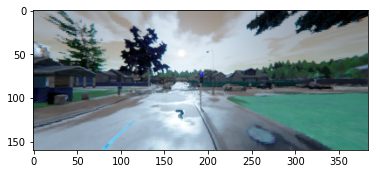

In [34]:
rgb = decode_frame(900)['rgb']
plt.imshow(rgb)

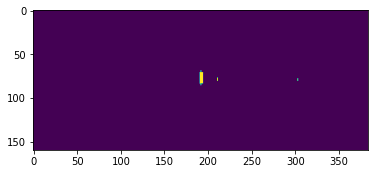

In [35]:
seg = decode_frame(900)['segmentation']
plt.imshow(seg==18)

In [ ]:
dataset.keys()


dict_keys(['birdview_0000', 'birdview_0001', 'birdview_0002', 'birdview_0003', 'birdview_0004', 'birdview_0005', 'birdview_0006', 'birdview_0007', 'birdview_0008', 'birdview_0009', 'birdview_0010', 'birdview_0011', 'birdview_0012', 'birdview_0013', 'birdview_0014', 'birdview_0015', 'birdview_0016', 'birdview_0017', 'birdview_0018', 'birdview_0019', 'birdview_0020', 'birdview_0021', 'birdview_0022', 'birdview_0023', 'birdview_0024', 'birdview_0025', 'birdview_0026', 'birdview_0027', 'birdview_0028', 'birdview_0029', 'birdview_0030', 'birdview_0031', 'birdview_0032', 'birdview_0033', 'birdview_0034', 'birdview_0035', 'birdview_0036', 'birdview_0037', 'birdview_0038', 'birdview_0039', 'birdview_0040', 'birdview_0041', 'birdview_0042', 'birdview_0043', 'birdview_0044', 'birdview_0045', 'birdview_0046', 'birdview_0047', 'birdview_0048', 'birdview_0049', 'birdview_0050', 'birdview_0051', 'birdview_0052', 'birdview_0053', 'birdview_0054', 'birdview_0055', 'birdview_0056', 'birdview_0057', 'bi

In [ ]:
seg = decode_frame(550)['segmentation']
print(np.unique(seg))
print(seg[50:100,230:250])
plt.imshow(seg)

In [ ]:
print(len(n_red_frames_t)/sum(n_frames_t))
print(sum(n_red_frames_v)/sum(n_frames_v))

In [ ]:
n_red_frames_t

In [ ]:
avg_tl = np.mean(tl)
avg_rate = np.mean(tl_frames_percentage)
print(avg_tl, avg_rate)

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=[tl_t.astype('float'), tl_v.astype('float')])
ax = sns.boxplot(..., labels=["Metric", "Length"])
plt.ylabel("Red traffic lights per episode", size=14)
plt.xlabel("Dataset", size=14)
plt.title("Repartition of red traffic lights in train and val dataset", size=18)
plt.savefig("comprtl.png")

In [ ]:
data = [tl_t, tl_t]
fig7, ax7 = plt.subplots()
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data)
ax7.legend(labels=['dsdssd','dssd'])
plt.show()

In [ ]:
tl_perc_t

### 1.2 Explore dataset

### 1.2 Inspect traffic lights state

In [ ]:
is_red_tl = []
speed = []
for i in range(int(out['len'].decode())):
    is_red_tl.append(decode_frame(i)['trafficlights'])
    meas = decode_frame(i)['measurements']
    # Measurements: [ox, oy, oz, ori_ox, ori_oy, vx, vy, vz, _, _, _, _, _, _, ax, ay, az, cmd, steer, throttle, brake, manual, gear]
    vel = meas[5:8]
    speed.append(np.linalg.norm(vel))

c = Counter(is_red_tl)
total = sum(c.values())
mapping = {1: 'Red', 0:'Green/Yellow/None'}
print(["{}: {} ({})%".format(mapping.get(k, k), round(v / total * 100, 1), v) for k, v in c.items()])

In [ ]:
fig,ax=plt.subplots()
ax.plot(range(len(is_red_tl)),is_red_tl, 'r--')
ax.set_xlabel("Frame")
ax.set_ylabel("Red light", color='red')

ax2=ax.twinx()
ax2.plot(range(len(is_red_tl)), speed, 'b')
ax2.set_ylabel("Speed [m/s]", color='blue')
plt.show()

In [ ]:
frames_with_red = []
for i in range(len(is_red_tl)):
    if(is_red_tl[i]==1):
        frames_with_red.append(i)
frames_with_red

In [ ]:
frame_of_interest = decode_frame(700)

In [ ]:
rgb=frame_of_interest['rgb']
resized = cv2.resize(rgb, (int(rgb.shape[1]/2), int(rgb.shape[0]/2)), interpolation = cv2.INTER_AREA)
cv2.imwrite('a.png', cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

In [ ]:
plt.imshow(frame_of_interest['segmentation'][:,:,0]==12) # Carla TL semantic seg channel

In [ ]:
plt.imshow(rgb)
plt.axis('off')
plt.savefig('rgb.png', bbox_inches='tight', pad_inches=0)

In [ ]:
a=frame_of_interest['segmentation'][:, :, 0]
plt.imshow(a)
plt.axis('off')
plt.savefig('seg.png', bbox_inches='tight', pad_inches=0)

In [ ]:
bv=frame_of_interest['birdview']
print(bv.shape[0:2])
b=np.zeros(bv.shape[0:2])
for k in range(bv.shape[2]):
    b[bv[:,:,k] != 0] = k
    #mask[..., i][seg == i] = 1
plt.imshow(b)
plt.axis('off')
plt.savefig('bv.png', bbox_inches='tight', pad_inches=0)

In [ ]:
# Red Traffic light birdview binary mask
plt.imshow(frame_of_interest['birdview'][:,:,2])
plt.axis('off')
plt.savefig('bvtl.png', bbox_inches='tight', pad_inches=0)

In [ ]:
def draw_frame(frame, i):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (int(0.1*frame.shape[0]), int(0.9*frame.shape[0]))
    fontScale              = 1
    fontColor              = [0,255,0]
    fontColor2              = [255,0,0]
    lineType               = 2
    printed_frame = cv2.putText(frame.copy(),'Frame: '+str(i), 
            bottomLeftCornerOfText, font, fontScale, fontColor, lineType);
    return printed_frame

video = cv2.VideoWriter('videos/dataset_23_09_overview.avi', 0, 10, (384, 160))
for i in range(int(out['len'].decode())):
    drawn_frame = draw_frame(decode_frame(i)['rgb'], i)
    video.write(drawn_frame)
video.release()

In [ ]:
#from IPython.core.display import Video
#Video("videos/dataset_23_09_overview.mp4", embed=True)